This scripts aggregate the mixed effect models

### Import


In [1]:
library(rstatix)
library(feather)
library(tidyverse)
library(rjson)
library(lme4)
library(reticulate)
library(ggeffects)
library(broom)
library(glue)
library(progress)
library(ggforce)
library(patchwork)
library(ggpubr)

knitr::opts_chunk$set(
  fig.show = "hold",
  fig.width = 7,
  fig.asp = 0.6
)



Attaching package: 'rstatix'


The following object is masked from 'package:stats':

    filter


-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.0     v purrr   0.3.4
v tibble  3.0.1     v dplyr   0.8.5
v tidyr   1.0.3     v stringr 1.4.0
v readr   1.3.1     v forcats 0.5.0

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks rstatix::filter(), stats::filter()
x dplyr::lag()    masks stats::lag()

Loading required package: Matrix


Attaching package: 'Matrix'


The following objects are masked from 'package:tidyr':

    expand, pack, unpack


Registered S3 methods overwritten by 'lme4':
  method                          from
  cooks.distance.influence.merMod car 
  influence.merMod                car 
  dfbeta.influence.merMod         car 
  dfbetas.influence.merMod        car 


Attaching package: 'glue'


The following object is masked from 'package:dplyr':

    collapse




### Load data

In [18]:
data_merged <- readRDS('E:/in_vivo_vr/sarah_glm_202006/all_lme.rds') #load previous data

In [19]:
data_merged <- data_merged %>%
    mutate(lm_result_outbound = recode(lm_result_outbound, 'NoSlope'='Unclassified','None'='Unclassified'))

### Plot portion of cell encoding position or time 

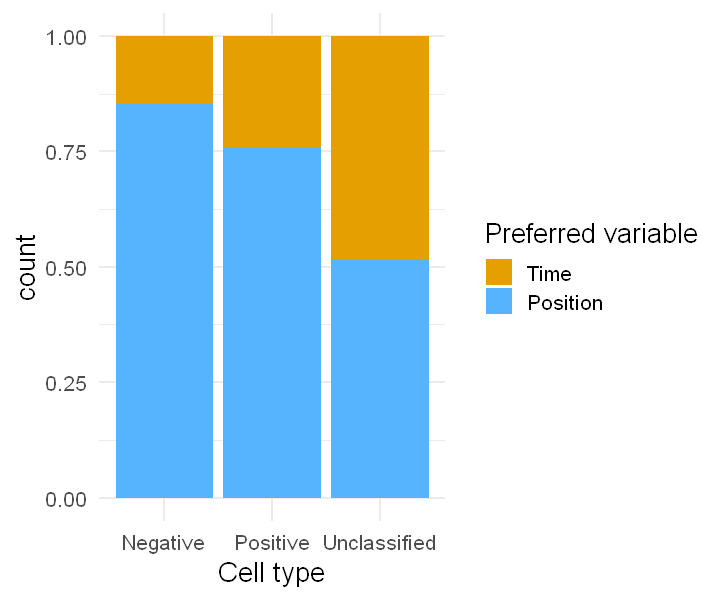

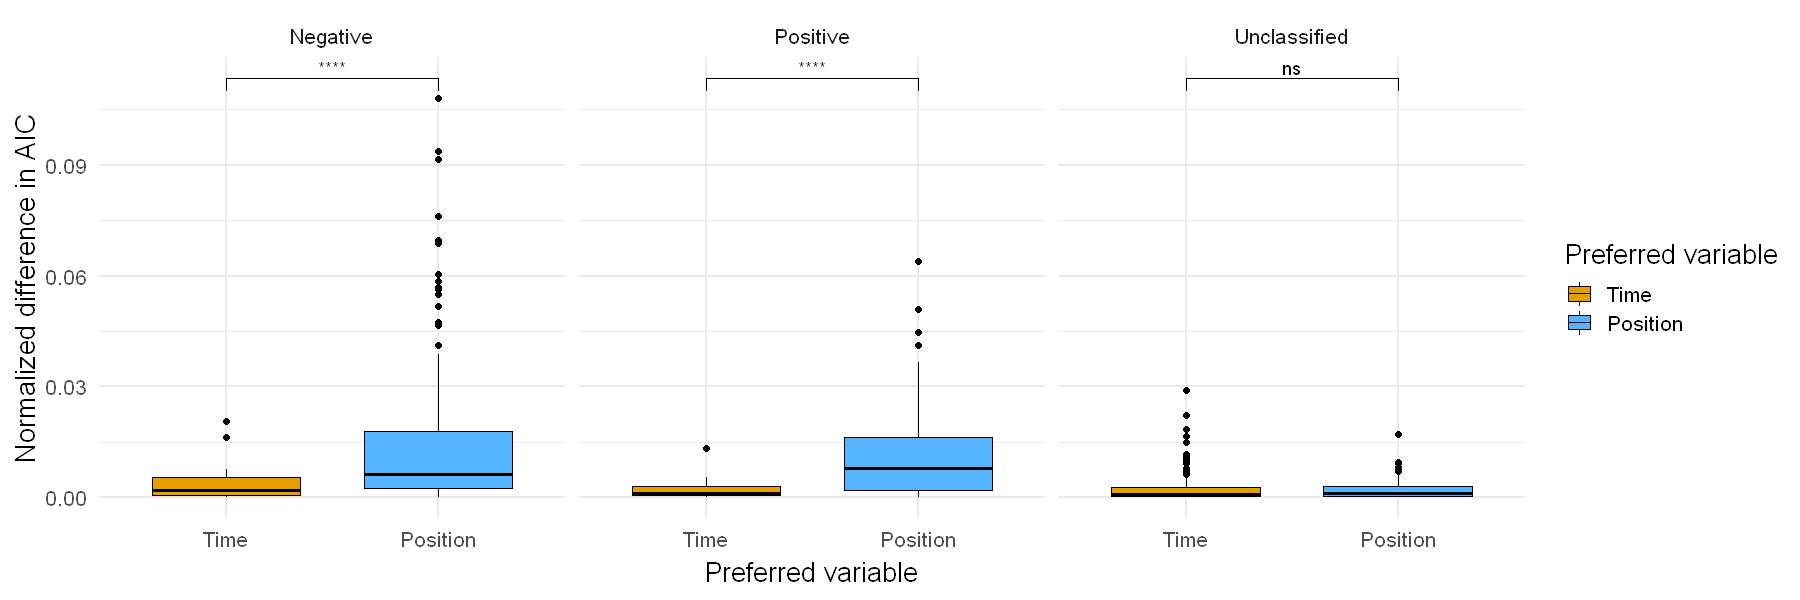

In [74]:
# use AIC for model comparison
options(repr.plot.width=6, repr.plot.height=5)

getPosAIC <- function(data) {
  data$AIC[[2]]
}

getTimeAIC <- function (data) {
  data$AIC[[1]]
}

data2plot <- data_merged %>%
  filter(trialN>10) %>% #only include data with enough trials
  filter(trial_length_type != "Middle") %>%
  mutate(pos_aic = map_dbl(anova_p_vs_t, getPosAIC)) %>%
  mutate(time_aic = map_dbl(anova_p_vs_t, getTimeAIC))  %>%
  mutate(aic_diff = abs(time_aic - pos_aic)/((pos_aic+time_aic)/2))

data2plot <- data2plot %>% 
  mutate(aic_compare=if_else(pos_aic<=time_aic,'Position','Time')) %>%
  mutate(aic_compare=factor(aic_compare,levels=c('Time','Position')))

p1 <- data2plot %>% 
    filter(trial_length_type=='All') %>%
    ggplot()+ 
      geom_bar(aes(x=lm_result_outbound,fill=aic_compare),position='fill') +
   labs(x='Cell type', fill='Preferred variable') +
    scale_fill_manual(values=c("#E69F00","#56B4FF")) +
      theme_minimal(base_size=16) 
p1
ggsave('paper_figures/3D.pdf',width=7,height=5)

options(repr.plot.width=15, repr.plot.height=5)

# outbound 
comparison <- list(c("Time","Position"))
p2 <- data2plot %>%
  filter(trial_length_type=="All") %>%
  ggboxplot(x="aic_compare",y="aic_diff", fill="aic_compare",
            facet.by='lm_result_outbound') +
    scale_fill_manual(values=c("#E69F00","#56B4FF")) +
  stat_compare_means(comparison=comparison, method='wilcox.test',label = "p.signif") + 
 labs(fill='Preferred variable', x = 'Preferred variable', y="Normalized difference in AIC") +
 theme_minimal(base_size=16)
p2
ggsave('paper_figures/3E.pdf',width=15,height=5)

# p1+p2 + plot_layout(widths = c(1, 2))

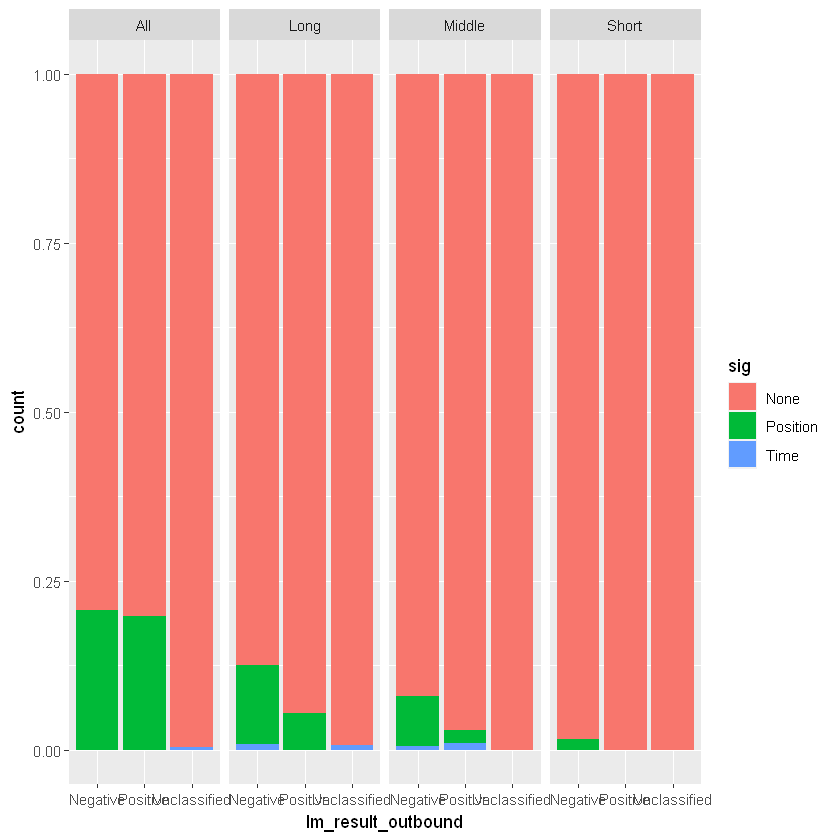

In [8]:
# Cross-validatino model comparison
# data_merged %>% 
#   mutate(sig=if_else(pvalue<0.05,'sig','non-sig')) %>%
#   ggplot() +
#   geom_bar(aes(x=lm_result_outbound,fill=sig),position='fill') +
#   facet_grid(~trial_length_type)

get_crossVal_p <- function(metrics){
  m <- metrics %>%
    group_by(model_type) %>%
    summarise(averageMSE=mean(metrics_rmse))
  
  m$averageMSE[[1]] - m$averageMSE[[2]] #position-time
}

data_merge2 <- data_merged %>%
  filter(trialN>10) %>%
  mutate(dMSE=map(metrics,get_crossVal_p)) %>%
  mutate(sig='None') %>%
  mutate(sig = if_else((pvalue<0.05) & (dMSE<0), 'Position',sig)) %>%
  mutate(sig = if_else((pvalue<0.05) & (dMSE>0), 'Time',sig))


ggplot(data_merge2) +
  geom_bar(aes(x=lm_result_outbound,fill=sig),position='fill') +
  facet_grid(~trial_length_type)

# ggplot(data_merge2) +
#   geom_bar(aes(x=lm_result_outbound,fill=sig)) +
#   facet_grid(~trial_length_type)


# ggplot(data_merge2) +
#   geom_bar(aes(x=lm_result_homebound,fill=sig)) +
#   facet_grid(~trial_length_type)

# ggplot(data_merge2) +
#   geom_bar(aes(x=lm_result_homebound,fill=sig),position='fill') +
#   facet_grid(~trial_length_type)
  
  

### get the mix effect response curve

In [ ]:
data_ramp <- data_merged %>%
    filter(lm_result_outbound != "None")

# refit the model
fmlStrTime= "firingRate ~ time_relative_outbound +(1|trial_number)"
fmlStrPos= "firingRate ~ position_relative_outbound +(1|trial_number)"

fit_lmer <- function(df,fmlStr) {
  return(lmer(as.formula(fmlStr),data=df))

}

data_ramp <- data_ramp %>%
    mutate(time_model=map(data, fit_lmer, fmlStrTime)) %>% #time model
    mutate(pos_model=map(data, fit_lmer, fmlStrPos))   #position model

    
df_plot <- data_ramp %>%
  mutate(marginalEffectTime = map(time_model, ggpredict, terms=c("time_relative_outbound"))) %>%
  mutate(marginalEffectPos = map(pos_model, ggpredict,terms=c("position_relative_outbound")))

df_plot <- df_plot %>%
  gather(starts_with('marginalEffect'),key='marginal_type',value='margin_effect')


### Save/Load plot data

In [ ]:
# saveRDS(df_plot,'E:/in_vivo_vr/sarah_glm_202006/all_lme_plot.rds', compress = FALSE)

df_plot <- readRDS('E:/in_vivo_vr/sarah_glm_202006/all_lme_plot.rds' )


df_plot$trialN <- as.numeric(df_plot$trialN)

df_predict <- df_plot %>%
  arrange(desc(trialN)) %>%
  unnest(margin_effect)

predict_data <- df_plot %>%
    arrange(desc(trialN)) %>%
  select(-session_id) %>%
  unnest(data)



In [ ]:

plot_lme_predicted <- function(df_model, df_data, p) {
  #Plot the predicted response from LME model
  
  #remove the trials that are too long to make plots easier to see
  df_model <- df_model %>%
    filter(x<=15)
  
  ggplot(df_model) +
  geom_line(aes(x=x,y=predicted,color=trial_length_type)) +
  geom_ribbon(aes(x=x,ymin=predicted-std.error, 
                  ymax = predicted + std.error,color=trial_length_type), fill = "lightgrey", alpha = 0.5) +
  # geom_point(data = df_data, aes(x=time_relative_outbound, y = firingRate, color=trial_length_type),
  #            alpha=0.3, shape='bullet') +
  labs(x='Time(s)', y='Firing Rate (Hz)') +
  facet_wrap_paginate(vars(session_id,cluster_id),scale='free',ncol = 4, nrow=4, page=p) +
  theme_minimal()
}

### Plot fitted curves - positive
-TODO fix bug

In [ ]:

# The model data
ramp_pos <- predict_time %>%
  filter(trial_length_type != 'All') %>%
  filter(lm_result_outbound=='Positive')

  
ramp_pos_data <- predict_data %>%
    filter(trial_length_type != 'All') %>%
    filter(lm_result_outbound=='Positive') 

p <- plot_lme_predicted(ramp_pos, ramp_pos_data,1)


pages <- n_pages(p)

pdf("figures/pos_ramp_lme.pdf", width = 12, height = 12*0.5)
for(i in seq(pages)){
  p <- plot_lme_predicted(ramp_pos, ramp_pos_data,i)
  print(p)
}
dev.off()

# For record in rmarkdown
for(i in seq(pages)){
  p <- plot_lme_predicted(ramp_pos, ramp_pos_data,i)
  print(p)
}


In [ ]:
df_filt <- df_plot %>%
  select(session_id, cluster_id, trialN) %>%
  filter(trial_length_type=='All') %>%
  filter(trialN>10)

session_sel <- df_filt$session_id

In [ ]:
# ramp cell, time vs position

plot_lme_predicted_time <- function(df_model, df_data, page, average=FALSE) {
  #Plot the predicted response from LME model
  
  #remove the trials that are too long to make plots easier to see
  df_model <- df_model %>%
    filter(x<=15)
  
  df_data <- df_data %>%
    filter(time_relative_outbound<=15)
  
  p <- ggplot(df_model)
  
  if(average) {
    p <- p + geom_smooth(aes(x=time_relative_outbound, y = firingRate, color=trial_length_type),data=df_data)
  }else{
    p <- p + geom_line(data = df_data, aes(x=time_relative_outbound, y = firingRate, color=trial_length_type, group=trial_number),
             alpha=0.3, shape='bullet')
  }
  
    p+geom_line(data=df_model,aes(x=x,y=predicted,color=trial_length_type)) +
    geom_ribbon(aes(x=x,ymin=predicted-std.error, 
                  ymax = predicted + std.error,color=trial_length_type), fill = "lightgrey", alpha = 0.5) +
    labs(x='Time(s)', y='Firing Rate (Hz)') +
    facet_wrap_paginate(vars(session_id, cluster_id, trial_length_type),scale='free',ncol = 6, nrow=4, page=page) +
    theme_minimal()

}

plot_lme_predicted_pos <- function(df_model, df_data, page, average=FALSE) {
  #Plot the predicted response from LME model
  

  p <- ggplot(df_model)
  
  if(average) {
    p <- p + geom_smooth(aes(x=position_relative_outbound, y = firingRate, color=trial_length_type),data=df_data)
  }else{
    p <- p + geom_line(data = df_data, aes(x=position_relative_outbound, y = firingRate, color=trial_length_type, group=trial_number),
             alpha=0.3, shape='bullet')
  }
  
    p+geom_line(data=df_model,aes(x=x,y=predicted,color=trial_length_type)) +
    geom_ribbon(aes(x=x,ymin=predicted-std.error, 
                  ymax = predicted + std.error,color=trial_length_type), fill = "lightgrey", alpha = 0.5) +
    labs(x='Position (cm)', y='Firing Rate (Hz)') +
    facet_wrap_paginate(vars(session_id, cluster_id, trial_length_type),scale='free',ncol = 6, nrow=4, page=page) +
    theme_minimal()

}


ramp_pos <- df_predict %>%
  filter(trial_length_type != 'All') %>%
  filter(lm_result_outbound=='Positive') %>%
  filter(marginal_type=='marginalEffectPos') %>%
  filter(session_id %in% session_sel)

  
ramp_pos_data <- predict_data %>%
    filter(trial_length_type != 'All') %>%
    filter(lm_result_outbound=='Positive')  %>%
    filter(marginal_type=='marginalEffectPos') %>%
     filter(session_id %in% session_sel)



plot_lme_predicted_pos(ramp_pos, ramp_pos_data, 1, average = TRUE)
plot_lme_predicted_pos(ramp_pos, ramp_pos_data, 1, average = FALSE)

ramp_time <- df_predict %>%
  filter(trial_length_type != 'All') %>%
  filter(lm_result_outbound=='Positive') %>%
  filter(marginal_type=='marginalEffectTime') %>%
    filter(session_id %in% session_sel)


  
ramp_time_data <- predict_data %>%
    filter(trial_length_type != 'All') %>%
    filter(lm_result_outbound=='Positive')  %>%
    filter(marginal_type=='marginalEffectTime') %>%
      filter(session_id %in% session_sel)



plot_lme_predicted_time(ramp_time, ramp_time_data, 1, average = TRUE)
plot_lme_predicted_time(ramp_time, ramp_time_data, 1, average = FALSE)



### Plot fitted curves - negative

In [ ]:

ramp_neg <- predict_time %>%
    filter(trial_length_type != 'All') %>%
  filter(lm_result_outbound=='Negative') 
  
ramp_neg_data <- predict_data %>%
    filter(trial_length_type != 'All') %>%
    filter(lm_result_outbound=='Negative')

p <- plot_lme_predicted(ramp_neg, ramp_neg_data,1)


pages <- n_pages(p)

pdf("figures/neg_ramp_lme.pdf", width = 12, height = 12*0.5)
for(i in seq(pages)){
  p <- plot_lme_predicted(ramp_neg, ramp_neg_data,i)
  print(p)
}

dev.off()

for(i in seq(pages)){
  p <- plot_lme_predicted(ramp_neg, ramp_neg_data,i)
  print(p)
}


### Negative cell -raw

In [ ]:
ramp_pos <- df_predict %>%
  filter(trial_length_type != 'All') %>%
  filter(lm_result_outbound=='Negative') %>%
  filter(marginal_type=='marginalEffectPos') %>%
   filter(trialN>10)

  
ramp_pos_data <- predict_data %>%
    filter(trial_length_type != 'All') %>%
    filter(lm_result_outbound=='Negative')  %>%
    filter(marginal_type=='marginalEffectPos') %>%
   filter(trialN>10)



plot_lme_predicted_pos(ramp_pos, ramp_pos_data, 1, average = TRUE)
plot_lme_predicted_pos(ramp_pos, ramp_pos_data, 1, average = FALSE)

ramp_time <- df_predict %>%
  filter(trial_length_type != 'All') %>%
  filter(lm_result_outbound=='Negative') %>%
  filter(marginal_type=='marginalEffectTime') %>%
   filter(trialN>10)

  
ramp_time_data <- predict_data %>%
    filter(trial_length_type != 'All') %>%
    filter(lm_result_outbound=='Negative')  %>%
    filter(marginal_type=='marginalEffectTime') %>%
   filter(trialN>10)


plot_lme_predicted_time(ramp_time, ramp_time_data, 1, average = TRUE)
plot_lme_predicted_time(ramp_time, ramp_time_data, 1, average = FALSE)

### Calculate normalized firing rate

In [ ]:

getMaxFr <- function(data) {
  max(data$firingRate)
}

# Get max firing rate of each cells
fr_max <- data_merged %>%
  filter(trial_length_type=="All") %>%
  mutate(max_fr = map(data,getMaxFr)) %>%
  select(session_id, cluster_id, max_fr)

# Match back to the original 

data_merged_norm <- data_merged %>%
  select(-time_model,-pos_model) %>%
  inner_join(fr_max, by=c("session_id","cluster_id")) %>%
  select(-session_id) %>%
  unnest(data) 
#  

In [ ]:

data_merged_norm$max_fr = as.numeric(data_merged_norm$max_fr)

data_merged_norm <- data_merged_norm %>%
  mutate(firingRateNorm = firingRate/max_fr)

data_merged_norm$trial_length = as.numeric(data_merged_norm$trial_length)/10 #change to second



In [ ]:
saveRDS(data_merged_norm, 'E:/in_vivo_vr/sarah_glm_202006/data_merged_norm.rds' )
# data_merged_norm = readRDS('E:/in_vivo_vr/sarah_glm_202006/data_merged_norm.rds')

### Plot average time response

In [ ]:

plot_time_response <- function(data_merged_norm, ramp_sign, smooth_method=NULL, mad_factor=1){
  
  #Calculate the metrics
  data_median <- data_merged_norm %>%
  group_by(trial_length_type.x) %>%
  summarise(median = median(trial_length), 
            mad = mad(trial_length),
            mean = mean(trial_length),
            std = sd(trial_length))

  short_metrics <- data_median %>%
    filter(trial_length_type.x=='Short')
  
  middle_metrics <- data_median %>%
    filter(trial_length_type.x=='Middle')
  
  long_metrics <- data_median %>%
    filter(trial_length_type.x=='Long')
  
  all_metrics <- data_median %>%
    filter(trial_length_type.x=='All')
  
  data_merged_norm %>%
  filter(trial_length <= all_metrics$median+mad_factor*all_metrics$mad) %>%
  filter(lm_result_outbound==ramp_sign) %>%
  filter(trial_length_type.x != 'All') %>%
  filter((trial_length_type.x=='Short' & time_relative_outbound<=short_metrics$median) |
          (trial_length_type.x=='Middle' & time_relative_outbound<=middle_metrics$median) |
           (trial_length_type.x=='Long' & time_relative_outbound<=long_metrics$median)
  ) %>%
  ggplot(aes(x=time_relative_outbound, y=firingRateNorm, color=trial_length_type.x)) +
  # geom_point() +
  geom_smooth(method=smooth_method) +
    ylab('Firing rate (Hz)') +
    xlab('Time relative to start of outbound (s)') +
    labs(color='Trial Length')
}

q1 <- plot_time_response(data_merged_norm, 'Positive','lm')
q2 <- plot_time_response(data_merged_norm, 'Positive')
q3 <- plot_time_response(data_merged_norm, 'Positive','lm',mad_factor=2)
q4 <- plot_time_response(data_merged_norm, 'Positive', mad_factor=2)

q1+q2+q3+q4

ggsave('figures/time_response_overall_pos.png')

In [ ]:
q1 <- plot_time_response(data_merged_norm, 'Negative','lm')
q2 <- plot_time_response(data_merged_norm, 'Negative')
q3 <- plot_time_response(data_merged_norm, 'Negative','lm',mad_factor=2)
q4 <- plot_time_response(data_merged_norm, 'Negative', mad_factor=2)

q1+q2+q3+q4

ggsave('figures/time_response_overall_neg.png')

### Only plot position-encoding neurons

In [ ]:
data_merged_norm_p <- data_merged_norm %>%
  filter(lmer_result_outbound=="P")
q1 <- plot_time_response(data_merged_norm_p, 'Positive','lm')
q2 <- plot_time_response(data_merged_norm_p, 'Positive')
q3 <- plot_time_response(data_merged_norm_p, 'Positive','lm',mad_factor=2)
q4 <- plot_time_response(data_merged_norm_p, 'Positive', mad_factor=2)

q1+q2+q3+q4

ggsave('figures/time_response_overall_pos_position.png')

In [ ]:

data_merged_norm_p <- data_merged_norm %>%
  filter(lmer_result_outbound=="P")

q1 <- plot_time_response(data_merged_norm_p, 'Negative','lm')
q2 <- plot_time_response(data_merged_norm_p, 'Negative')
q3 <- plot_time_response(data_merged_norm_p, 'Negative','lm',mad_factor=2)
q4 <- plot_time_response(data_merged_norm_p, 'Negative', mad_factor=2)

q1+q2+q3+q4

ggsave('figures/time_response_overall_neg_position.png')

### Histogram of trial length (unfiltered)

In [ ]:

extractTrialLength <- function(data){
  return(data$trial_length[[1]])
}


d <- data_merged_norm %>%
  filter(lm_result_outbound=='Positive') %>%
  filter(trial_length_type.x != 'All') %>%
  group_by(session_id, trial_length_type.x, trial_number) %>%
  nest() %>%
  mutate(trial_length = map_dbl(data, extractTrialLength))

d %>%
  ungroup() %>%
  mutate(trial_length_time = trial_length) %>%
  filter(trial_length_time<100) %>%
ggplot(aes(x=trial_length_time, fill=trial_length_type.x)) +
  geom_histogram(binwidth = 0.1 ) +
  facet_zoom(xlim = c(0,10))

ggsave('figures/trial_dist_all.png')